In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
from pandas.tseries.offsets import BDay

from util.file_util import StockTwitsFileReader, StockDataFileReader
# from util.stocktwits_helper import 
from util.stockdata_helper import (
    get_nday_returns_for_ticker, get_nday_mkt_adjusted_returns_for_ticker)

from util.ts_util import (
    shift_date_index, calc_corr, 
    resample_weekly, rolling_weekly)
from util.plot_util import plot_time_series_bar, overlay_on_secondary_axis
import numpy as np
from config import STOCKTWITS_TICKER_LIST
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
start_date = '2018-01-01'
end_date = '2019-08-10'

In [5]:
twit_file_reader = StockTwitsFileReader() 
stock_file_reader = StockDataFileReader()

In [6]:
ticker_list = STOCKTWITS_TICKER_LIST

## Data Basic Stat Check by Ticker

- We should ignore tickers with only few Twits

In [7]:
stats = []

for ticker in ticker_list:
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    n_days = twit_df.shape[0]
    total_twits = twit_df.sum().sum()
    avg_twits = total_twits / n_days
    
    stats.append({
        'ticker': ticker, 
        'total_twits': total_twits,
        'avg_twits': avg_twits,
        'n_days': n_days,
    })

In [8]:
stat_df = pd.DataFrame(stats).sort_values('avg_twits', ascending=False)

In [9]:
stat_df[stat_df['avg_twits'] > 1.5]

,avg_twits,n_days,ticker,total_twits
2,789.490476,420,TSLA,331586.0
4,752.581081,74,BYND,55691.0
1,85.558195,421,MSFT,36020.0
3,23.197150,421,SBUX,9766.0
21,14.185185,405,GME,5745.0
31,9.769029,381,WWE,3722.0
0,7.342183,339,SHAK,2489.0
33,4.473154,298,SIG,1333.0
16,3.571429,224,AEO,800.0
29,2.223404,188,JACK,418.0


In [10]:
tickers_with_high_twits = stat_df.loc[stat_df['avg_twits'] > 1.5, 'ticker'].values
tickers_with_high_twits

array(['TSLA', 'BYND', 'MSFT', 'SBUX', 'GME', 'WWE', 'SHAK', 'SIG', 'AEO',
       'JACK', 'NUVA', 'ZBRA', 'EAT', 'PLT', 'OSK', 'ODFL', 'FDS'],
      dtype=object)

## Weekly Sentiment by Ticker

- Define stocks of interest based on graphs below

In [11]:
STOCKS_OF_INTEREST = [
    'TSLA', 
    'BYND', # look at it from 2019-05-01
    'MSFT', 
    'SBUX', 
    'GME', 
    'WWE', 
    'SHAK', 
    'SIG', 
    'AEO',
#     'JACK', 
#     'NUVA', 
#     'ZBRA', 
#     'PLT', 
#     'OSK', 
#     'EAT',
]

Questions to Answer

- What is the monthly spike in MSFT?
- Any indication from the spike in JACK?
- spikes in AEO?


In [79]:
sample_ticker = 'BYND'

In [80]:
sample_twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(sample_ticker)
sample_wkly_twit_df = resample_weekly(sample_twit_df)

sample_stock_df = stock_file_reader.read_stockdata_in_range(sample_ticker, start_date, end_date)

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


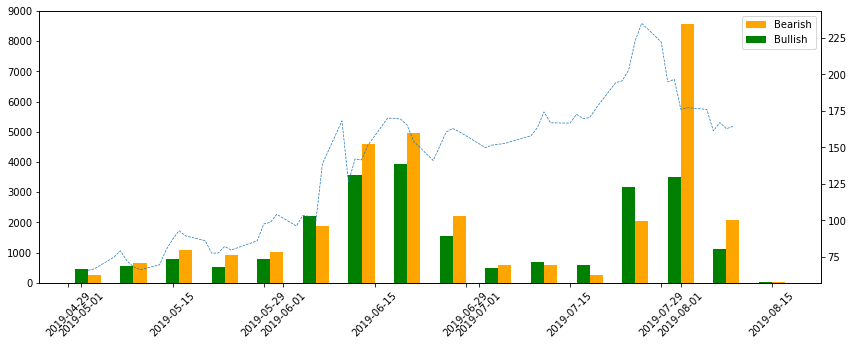

In [81]:
ax = plot_time_series_bar(sample_wkly_twit_df, 
                          figsize=(14, 5),)

overlay_on_secondary_axis(sample_stock_df, 'adjusted close', ax)

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warning

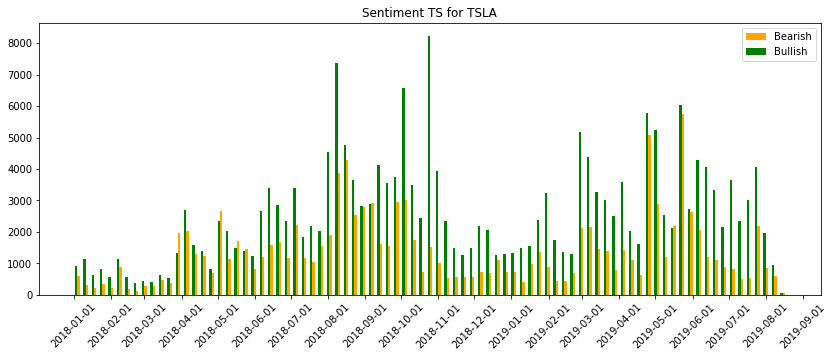

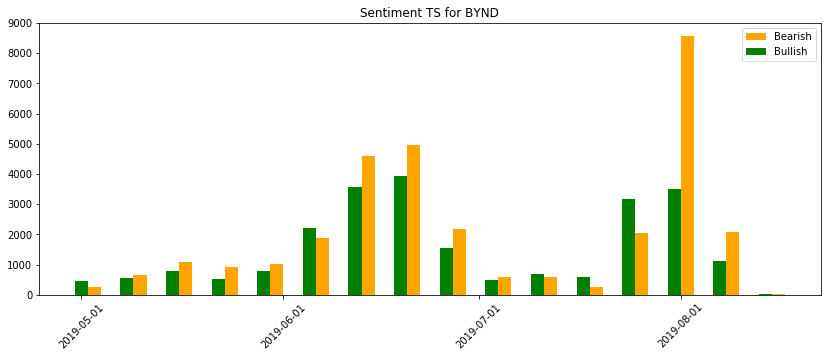

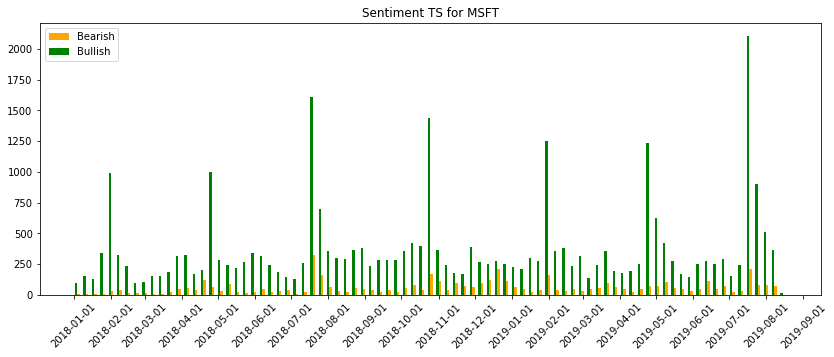

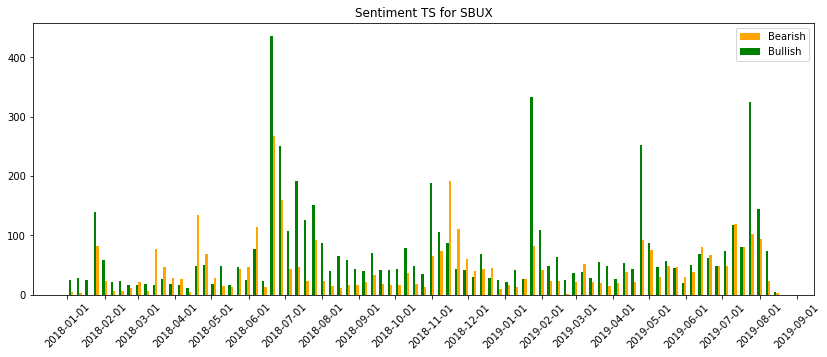

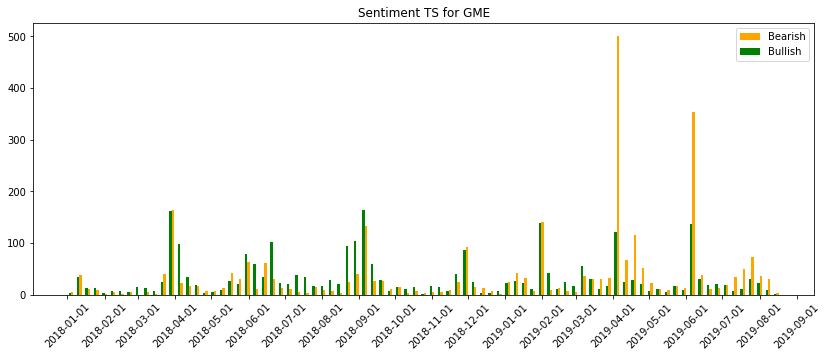

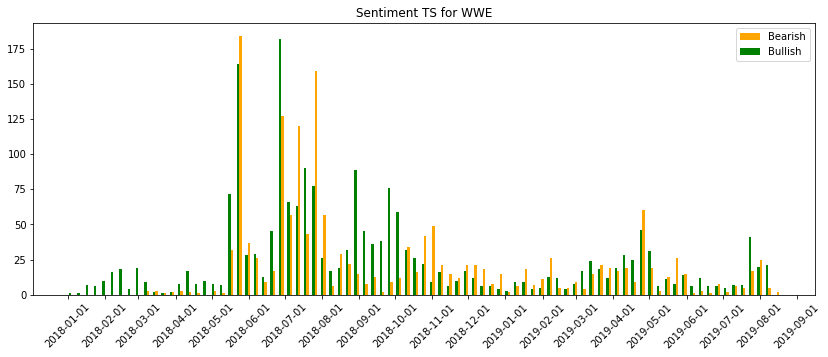

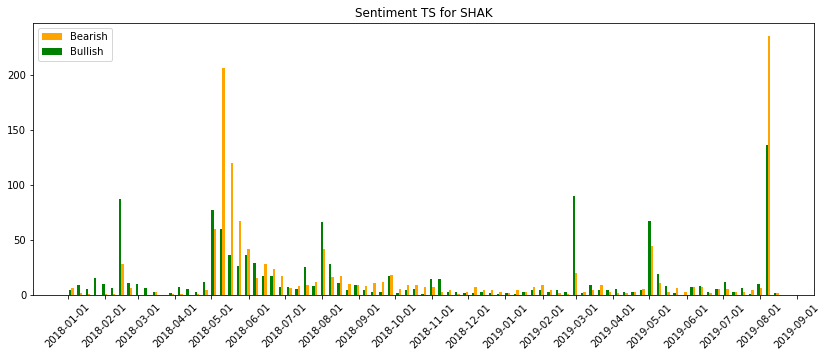

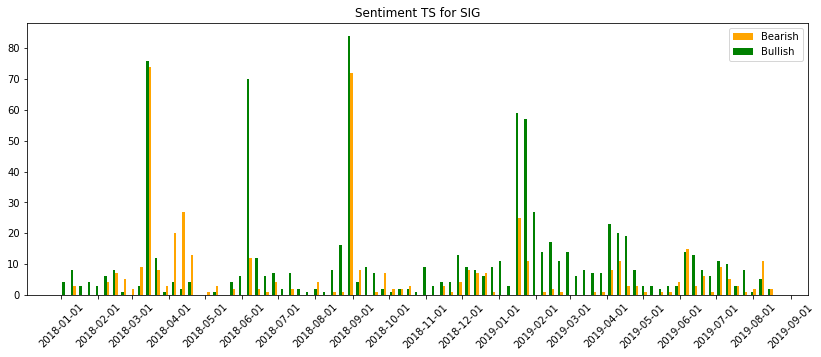

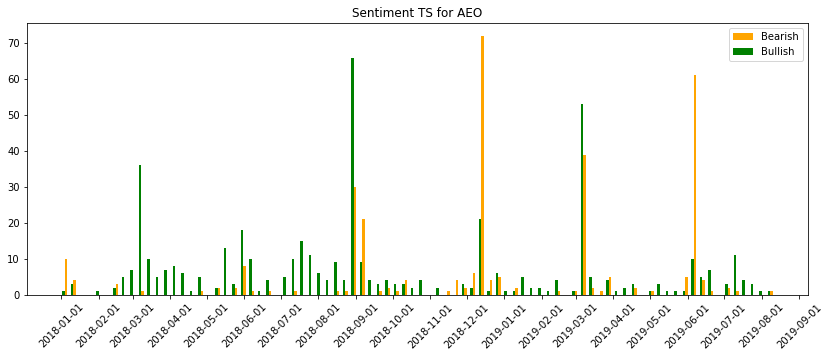

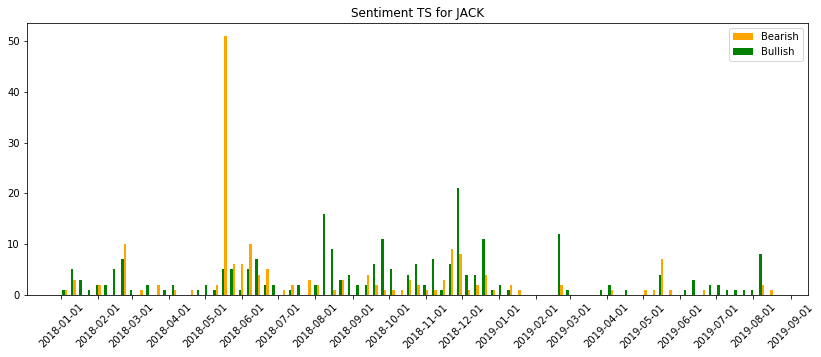

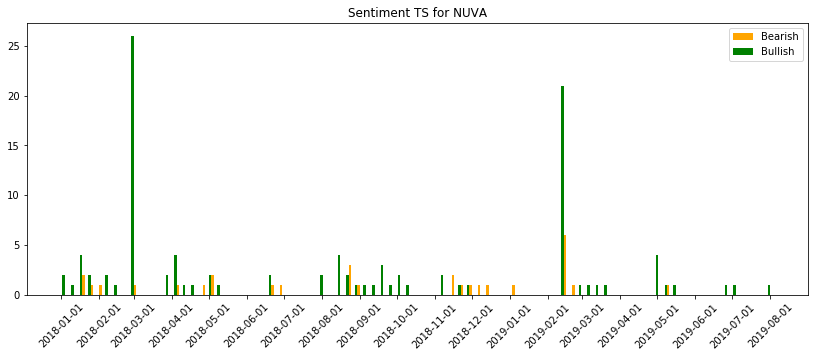

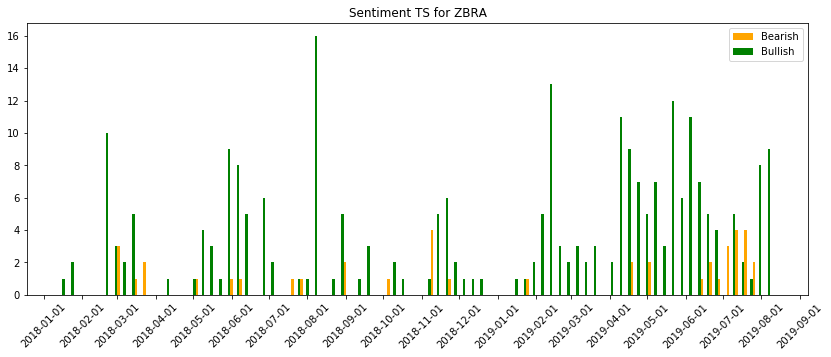

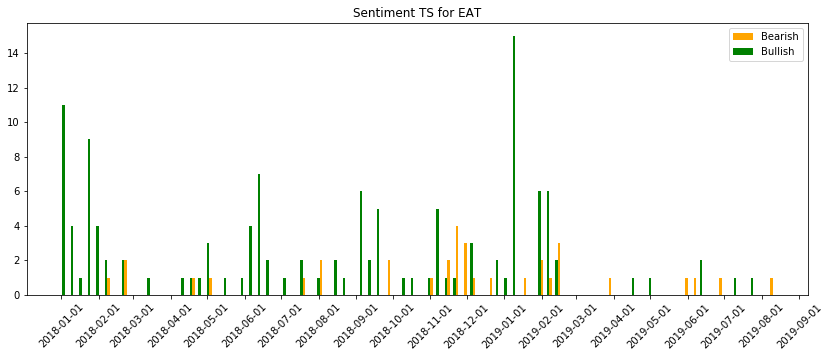

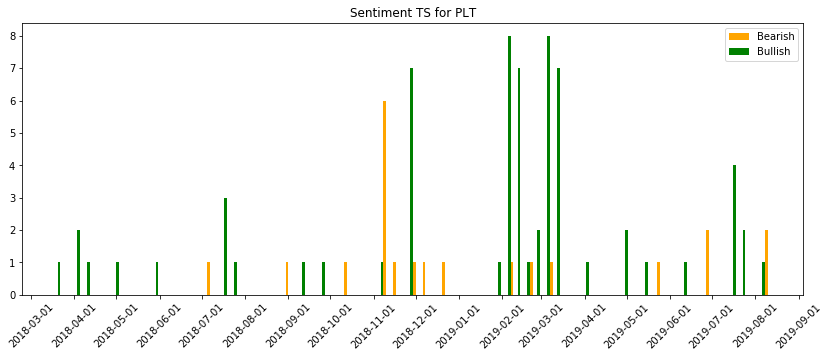

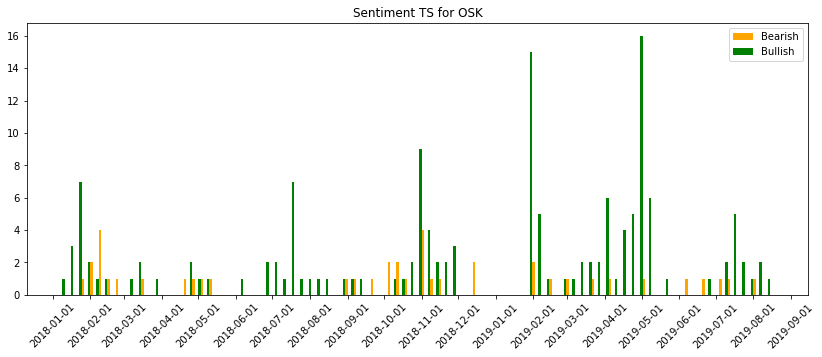

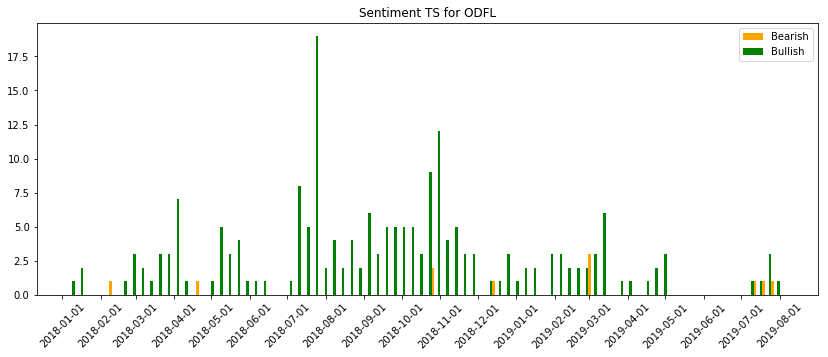

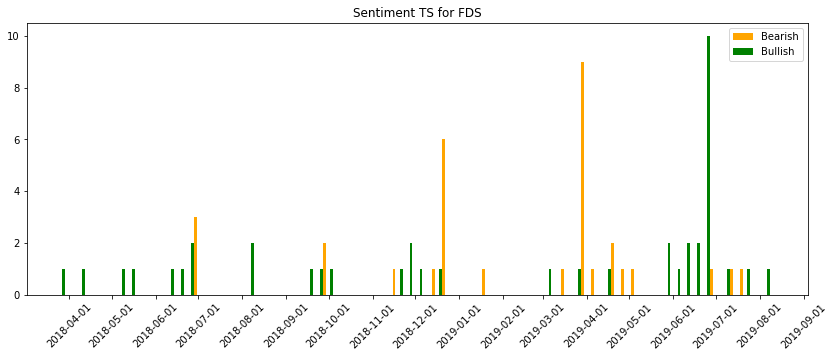

In [15]:
for ticker in tickers_with_high_twits:
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    
    wkly_twit_df_resample = resample_weekly(twit_df)
#     wkly_twit_df_rolling = rolling_weekly(twit_df)
    plot_time_series_bar(wkly_twit_df_resample, 
                         figsize=(14, 5),
                         title='Sentiment TS for {}'.format(ticker))

## Daily correlations by ticker / lag

In [16]:
import seaborn as sns

#### Bullish / Bearish

In [17]:
sentiment_type = 'Bullish'

In [18]:
n_lags = [-5, -3, -1, 0, 1, 3, 5]

In [20]:
corr_summary = []

for ticker in STOCKS_OF_INTEREST:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                 n_days=1)
    
    for lag in n_lags:
        if lag == 0:
            shifted_twit_df = twit_df
        else:
            shifted_twit_df = shift_date_index(twit_df, lag)

        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sentiment_type,
            'lag': lag,
            'corr': corr,
        })

In [21]:
corr_summary_df = pd.DataFrame(corr_summary)

In [22]:
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='lag').round(2)

In [23]:
corr_summary_pivot

lag,-5,-3,-1,0,1,3,5
ticker,,,,,,,
AEO,0.07,-0.09,0.04,-0.09,-0.15,0.07,-0.07
BYND,-0.05,0.13,0.26,0.23,-0.15,-0.12,-0.02
GME,-0.01,0.02,0.00,-0.22,0.05,0.09,0.04
MSFT,0.02,-0.02,-0.02,0.17,0.04,0.02,-0.09
SBUX,-0.02,-0.01,-0.09,0.14,-0.02,-0.01,-0.01
SHAK,0.05,0.02,0.10,0.17,-0.04,-0.01,0.01
SIG,-0.09,-0.15,-0.11,0.14,-0.02,-0.00,0.05
TSLA,0.04,0.08,-0.03,0.18,0.02,0.02,-0.04
WWE,0.07,0.21,0.24,0.31,0.07,0.05,0.03


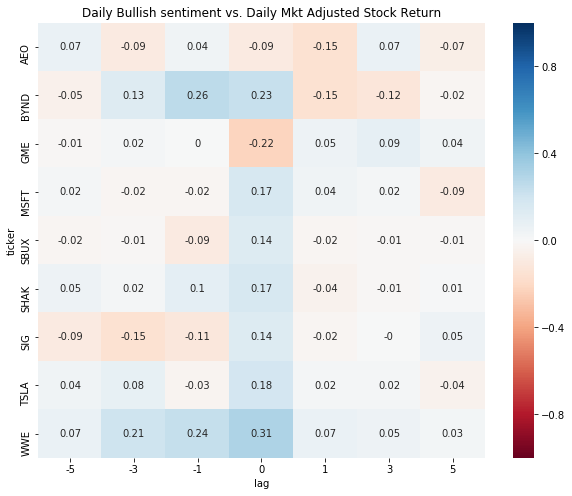

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Daily {} sentiment vs. Daily Mkt Adjusted Stock Return'.format(sentiment_type))

In [30]:
sent_calc_type = 'Bullish_Bearish_log_odds'

In [31]:
corr_summary = []

for ticker in STOCKS_OF_INTEREST:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                 n_days=1)
    
    for lag in n_lags:
        if lag == 0:
            shifted_twit_df = twit_df
        else:
            shifted_twit_df = shift_date_index(twit_df, lag)
            
        shifted_twit_df['Bullish_Minus_Bearish'] = shifted_twit_df['Bullish'] - shifted_twit_df['Bearish']
        shifted_twit_df['Bullish_Bearish_log_odds'] = np.log(shifted_twit_df['Bullish'] / shifted_twit_df['Bearish'])
        shifted_twit_df['Bullish_Sum_Bearish'] = shifted_twit_df['Bullish'] + shifted_twit_df['Bearish']
        
        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sent_calc_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sent_calc_type,
            'lag': lag,
            'corr': corr,
        })
        

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:16: Runt

In [32]:
corr_summary_df = pd.DataFrame(corr_summary)
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='lag').round(2)

In [33]:
corr_summary_pivot

lag,-5,-3,-1,0,1,3,5
ticker,,,,,,,
AEO,0.30,-0.29,-0.25,-0.05,0.23,0.26,-0.21
BYND,-0.05,-0.00,0.21,0.51,0.01,-0.06,0.03
GME,0.01,0.11,0.16,0.22,0.05,0.03,0.07
MSFT,-0.07,0.02,0.06,0.17,-0.03,0.02,-0.07
SBUX,0.01,-0.05,0.05,0.13,-0.03,0.04,-0.01
SHAK,-0.24,-0.18,-0.02,0.09,-0.05,-0.11,0.05
SIG,-0.11,-0.11,-0.11,0.15,0.03,-0.02,-0.05
TSLA,0.05,0.12,0.28,0.50,-0.04,-0.02,-0.03
WWE,-0.06,0.12,0.10,0.22,0.06,0.05,0.11


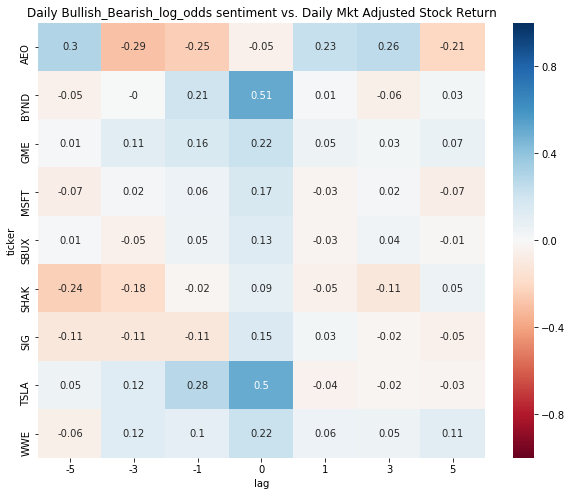

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Daily {} sentiment vs. Daily Mkt Adjusted Stock Return'.format(sent_calc_type))

## Correlation of Weekly Sentiment vs. Daily Return

In [35]:
sentiment_type = 'Bullish_Bearish_log_odds'

In [37]:
corr_summary = []

for ticker in STOCKS_OF_INTEREST:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    
    twit_rolling_weekly_df = rolling_weekly(twit_df)
    
    mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                 n_days=1)
    
    for lag in n_lags:
        if lag == 0:
            shifted_twit_df = twit_rolling_weekly_df
        else:
            shifted_twit_df = shift_date_index(twit_rolling_weekly_df, lag)
            
        shifted_twit_df['Bullish_Minus_Bearish'] = shifted_twit_df['Bullish'] - shifted_twit_df['Bearish']
        shifted_twit_df['Bullish_Bearish_log_odds'] = np.log(shifted_twit_df['Bullish'] / shifted_twit_df['Bearish'])

        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sentiment_type,
            'lag': lag,
            'corr': corr,
        })

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


In [38]:
corr_summary_df = pd.DataFrame(corr_summary)
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='lag').round(2)

In [39]:
corr_summary_pivot

lag,-5,-3,-1,0,1,3,5
ticker,,,,,,,
AEO,0.07,-0.01,0.07,0.05,0.14,0.06,-0.06
BYND,0.02,0.22,0.21,0.18,-0.02,0.09,-0.00
GME,0.05,0.15,0.14,0.13,0.06,0.05,0.07
MSFT,-0.01,0.06,0.06,0.06,-0.02,0.01,-0.00
SBUX,-0.03,0.05,0.06,0.05,-0.07,0.02,0.04
SHAK,-0.03,-0.02,-0.01,0.00,0.02,0.05,0.01
SIG,0.07,0.08,0.10,0.07,0.03,0.07,-0.04
TSLA,0.16,0.27,0.22,0.16,-0.05,-0.01,-0.03
WWE,0.13,0.17,0.08,0.09,0.06,0.11,0.06


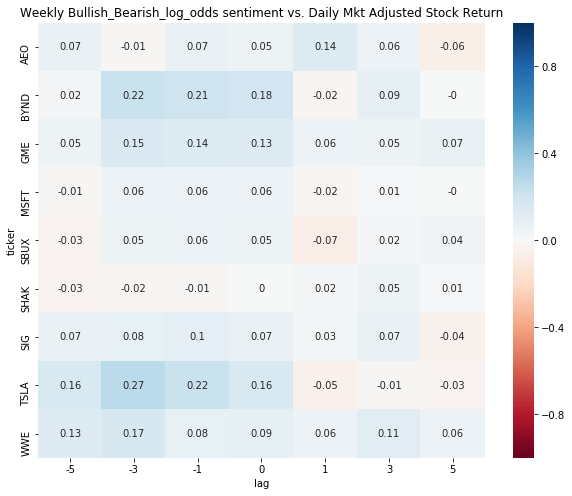

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Weekly {} sentiment vs. Daily Mkt Adjusted Stock Return'.format(sentiment_type))

### Correlation of Daily Sentiment vs. Different Range Returns

In [75]:
sentiment_type = 'Bullish_Minus_Bearish'

In [76]:
corr_summary = []

for ticker in STOCKS_OF_INTEREST:
    # lag is wrt stock twits (hence, lag = 1 means Twits lead by 1 day)
    twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker)
    
    for n_day in [1, 3, 5]:
    
        mkt_adjust_return = get_nday_mkt_adjusted_returns_for_ticker(ticker, start_date, end_date,
                                                                     n_days=n_day)
        shifted_twit_df = shift_date_index(twit_df, n_day)
        
        shifted_twit_df['Bullish_Minus_Bearish'] = shifted_twit_df['Bullish'] - shifted_twit_df['Bearish']
        shifted_twit_df['Bullish_Bearish_log_odds'] = np.log(shifted_twit_df['Bullish'] / shifted_twit_df['Bearish'])

        corr = calc_corr(shifted_twit_df, 
                         mkt_adjust_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': ticker,
            'sentiment_type': sentiment_type,
            'n_day_return': n_day,
            'corr': corr,
        })

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/i

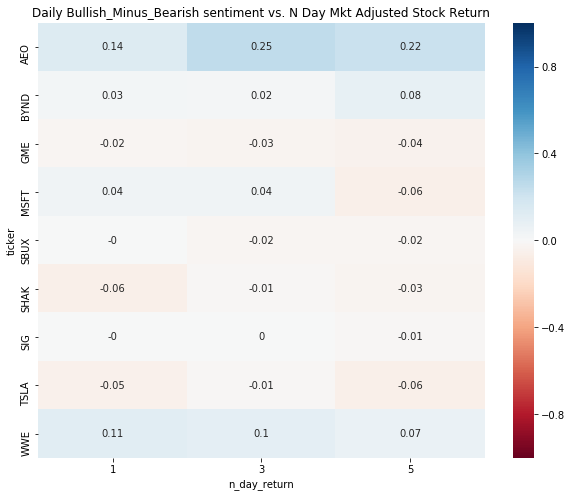

In [77]:
corr_summary_df = pd.DataFrame(corr_summary)
corr_summary_pivot = corr_summary_df.pivot_table(index='ticker', values='corr', columns='n_day_return').round(2)

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr_summary_pivot, 
                      annot=True, 
                      cmap='RdBu', 
                      ax=ax, 
                      center=0,
                      vmin=-1, vmax=1)
_ = heatmap.set_title('Daily {} sentiment vs. N Day Mkt Adjusted Stock Return'.format(sentiment_type))

In [78]:
corr_summary_pivot

n_day_return,1,3,5
ticker,,,
AEO,0.14,0.25,0.22
BYND,0.03,0.02,0.08
GME,-0.02,-0.03,-0.04
MSFT,0.04,0.04,-0.06
SBUX,-0.00,-0.02,-0.02
SHAK,-0.06,-0.01,-0.03
SIG,-0.00,0.00,-0.01
TSLA,-0.05,-0.01,-0.06
WWE,0.11,0.10,0.07
